# Machine Learning Project: T7 - Intrusion Detection AA. 24/25

<center>IURATO CHIARA: 0341704, MARTORELLI LUCA: 0357263</center>

## Context

The NSL-KDD dataset represents information on network traffic flows, with each record describing a specific flow or network session, characterized by a set of numerical and categorical features. A binary classification can be performed to distinguish between attacks and normal traffic.

## Methodology
1. **Dataset Loading**: Use pandas to load the KDD dataset.
2. **Preprocessing**:  Separate the features and labels. Encode any categorical variables in the feature set using techniques such as one-hot encoding or label encoding.
3. **Model Training**: Use various machine learning techniques to train the models.
4. **Evaluation**: Use performance metrics such as accuracy, precision, recall, F1-score, and confusion matrix to evaluate the models' effectiveness in classifying the attack types.
5. **Results Analysis**: Compare the models and select the best one.

# Uploading libraries
Let's begin to prepare all the libraries and load the dataset from the current directory.

In [62]:
import pandas as pd
import warnings
# Turn off the warnings.
warnings.filterwarnings(action='ignore')
import numpy as np
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, RocCurveDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.ensemble import RandomForestClassifier
import plotly.express as px
from sklearn.feature_selection import mutual_info_classif
from keras.layers import Dense,  Dropout
from keras.models import Sequential
from imblearn.under_sampling import NearMiss

In [4]:
df = pd.read_csv("KDDTrainClean.csv")
df.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal
1,0,udp,other,SF,146,0,0,0,0,0,...,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal
2,0,tcp,private,S0,0,0,0,0,0,0,...,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune
3,0,tcp,http,SF,232,8153,0,0,0,0,...,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal
4,0,tcp,http,SF,199,420,0,0,0,0,...,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal


In [5]:
df.info()
# Rename the labels that are not "normal" as "attack" to simplify the classification into normal vs. attack
df.loc[df['label'] != "normal", "label"] = 'attack' 
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125973 entries, 0 to 125972
Data columns (total 42 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   duration                     125973 non-null  int64  
 1   protocol_type                125973 non-null  object 
 2   service                      125973 non-null  object 
 3   flag                         125973 non-null  object 
 4   src_bytes                    125973 non-null  int64  
 5   dst_bytes                    125973 non-null  int64  
 6   land                         125973 non-null  int64  
 7   wrong_fragment               125973 non-null  int64  
 8   urgent                       125973 non-null  int64  
 9   hot                          125973 non-null  int64  
 10  num_failed_logins            125973 non-null  int64  
 11  logged_in                    125973 non-null  int64  
 12  num_compromised              125973 non-null  int64  
 13 

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal
1,0,udp,other,SF,146,0,0,0,0,0,...,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal
2,0,tcp,private,S0,0,0,0,0,0,0,...,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,attack
3,0,tcp,http,SF,232,8153,0,0,0,0,...,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal
4,0,tcp,http,SF,199,420,0,0,0,0,...,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal


Before proceeding with data preprocessing, let's take a look at how the data is distributed between the 'normal' and 'attack' classes.

## Data Visualization

In [37]:
class_counts = df['label'].value_counts()

fig = px.pie(
    names=class_counts.index, 
    values=class_counts.values, 
    title="Distribution of the classes (normal vs attack)",
    color_discrete_sequence=px.colors.qualitative.Set1  )

fig.show()

In [225]:
fig = px.histogram(df, x='protocol_type', color='label', barmode='group', 
                   color_discrete_sequence=px.colors.qualitative.Set1)
fig.update_layout(title_text="Distribution of Attack vs Normal for Protocol Types",
                  xaxis_title="Protocol Type", yaxis_title="Count")
fig.show()

We observe that the majority of attacks originate from TCP, followed by UDP, while ICMP accounts for the fewest attacks.

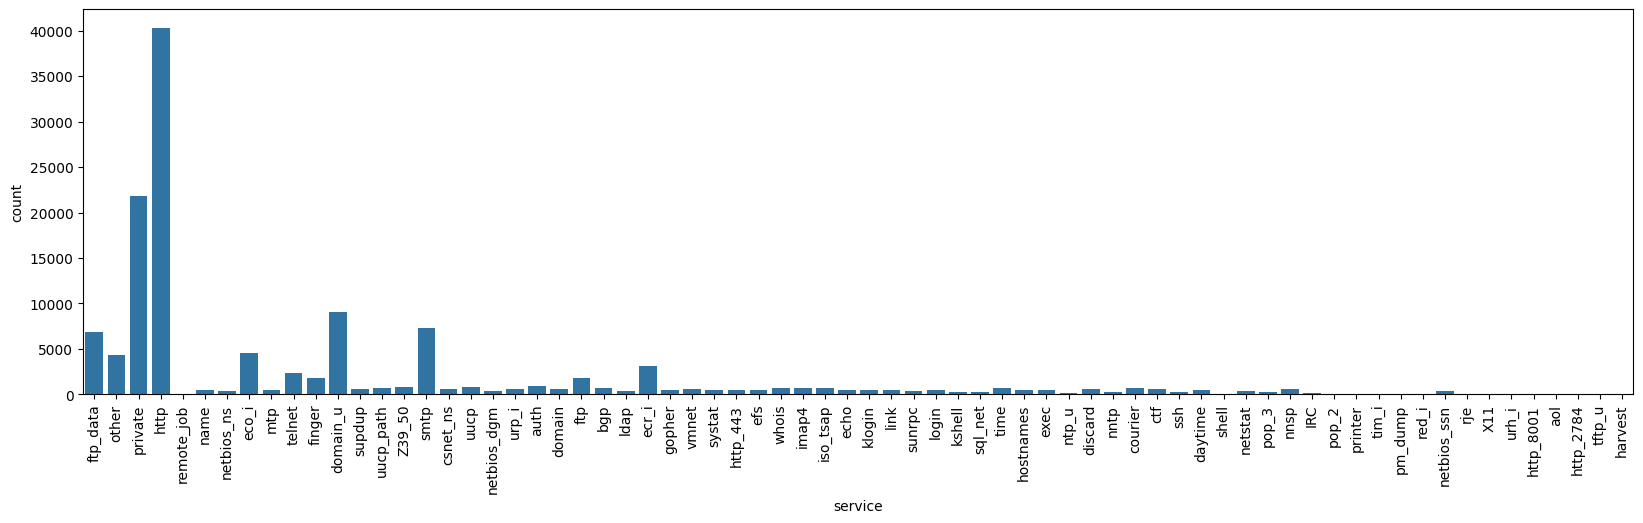

In [7]:
plt.figure(figsize=(20,5))
t = sns.countplot(x='service', data = df)
t.set_xticklabels(t.get_xticklabels(),rotation=90);


Obviously, HTTP is the most targeted service in DDoS attacks.

# Preprocessing

The KDD dataset contains several categorical features, such as protocol_type, service, flag, and label, which need to be encoded into numerical values to allow machine learning models to process them effectively.

In [38]:
# check if there are null values
print(df.isnull().values.any())

False


In [8]:
le = LabelEncoder()
df['protocol_type']=le.fit_transform(df['protocol_type'])
df['service']=le.fit_transform(df['service'])
df['flag']=le.fit_transform(df['flag'])
df['label']=le.fit_transform(df['label'])

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125973 entries, 0 to 125972
Data columns (total 42 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   duration                     125973 non-null  int64  
 1   protocol_type                125973 non-null  int64  
 2   service                      125973 non-null  int64  
 3   flag                         125973 non-null  int64  
 4   src_bytes                    125973 non-null  int64  
 5   dst_bytes                    125973 non-null  int64  
 6   land                         125973 non-null  int64  
 7   wrong_fragment               125973 non-null  int64  
 8   urgent                       125973 non-null  int64  
 9   hot                          125973 non-null  int64  
 10  num_failed_logins            125973 non-null  int64  
 11  logged_in                    125973 non-null  int64  
 12  num_compromised              125973 non-null  int64  
 13 

In [9]:
df.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
0,0,1,20,9,491,0,0,0,0,0,...,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,1
1,0,2,44,9,146,0,0,0,0,0,...,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,1
2,0,1,49,5,0,0,0,0,0,0,...,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,0
3,0,1,24,9,232,8153,0,0,0,0,...,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,1
4,0,1,24,9,199,420,0,0,0,0,...,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1


## Correlation between features

<Axes: >

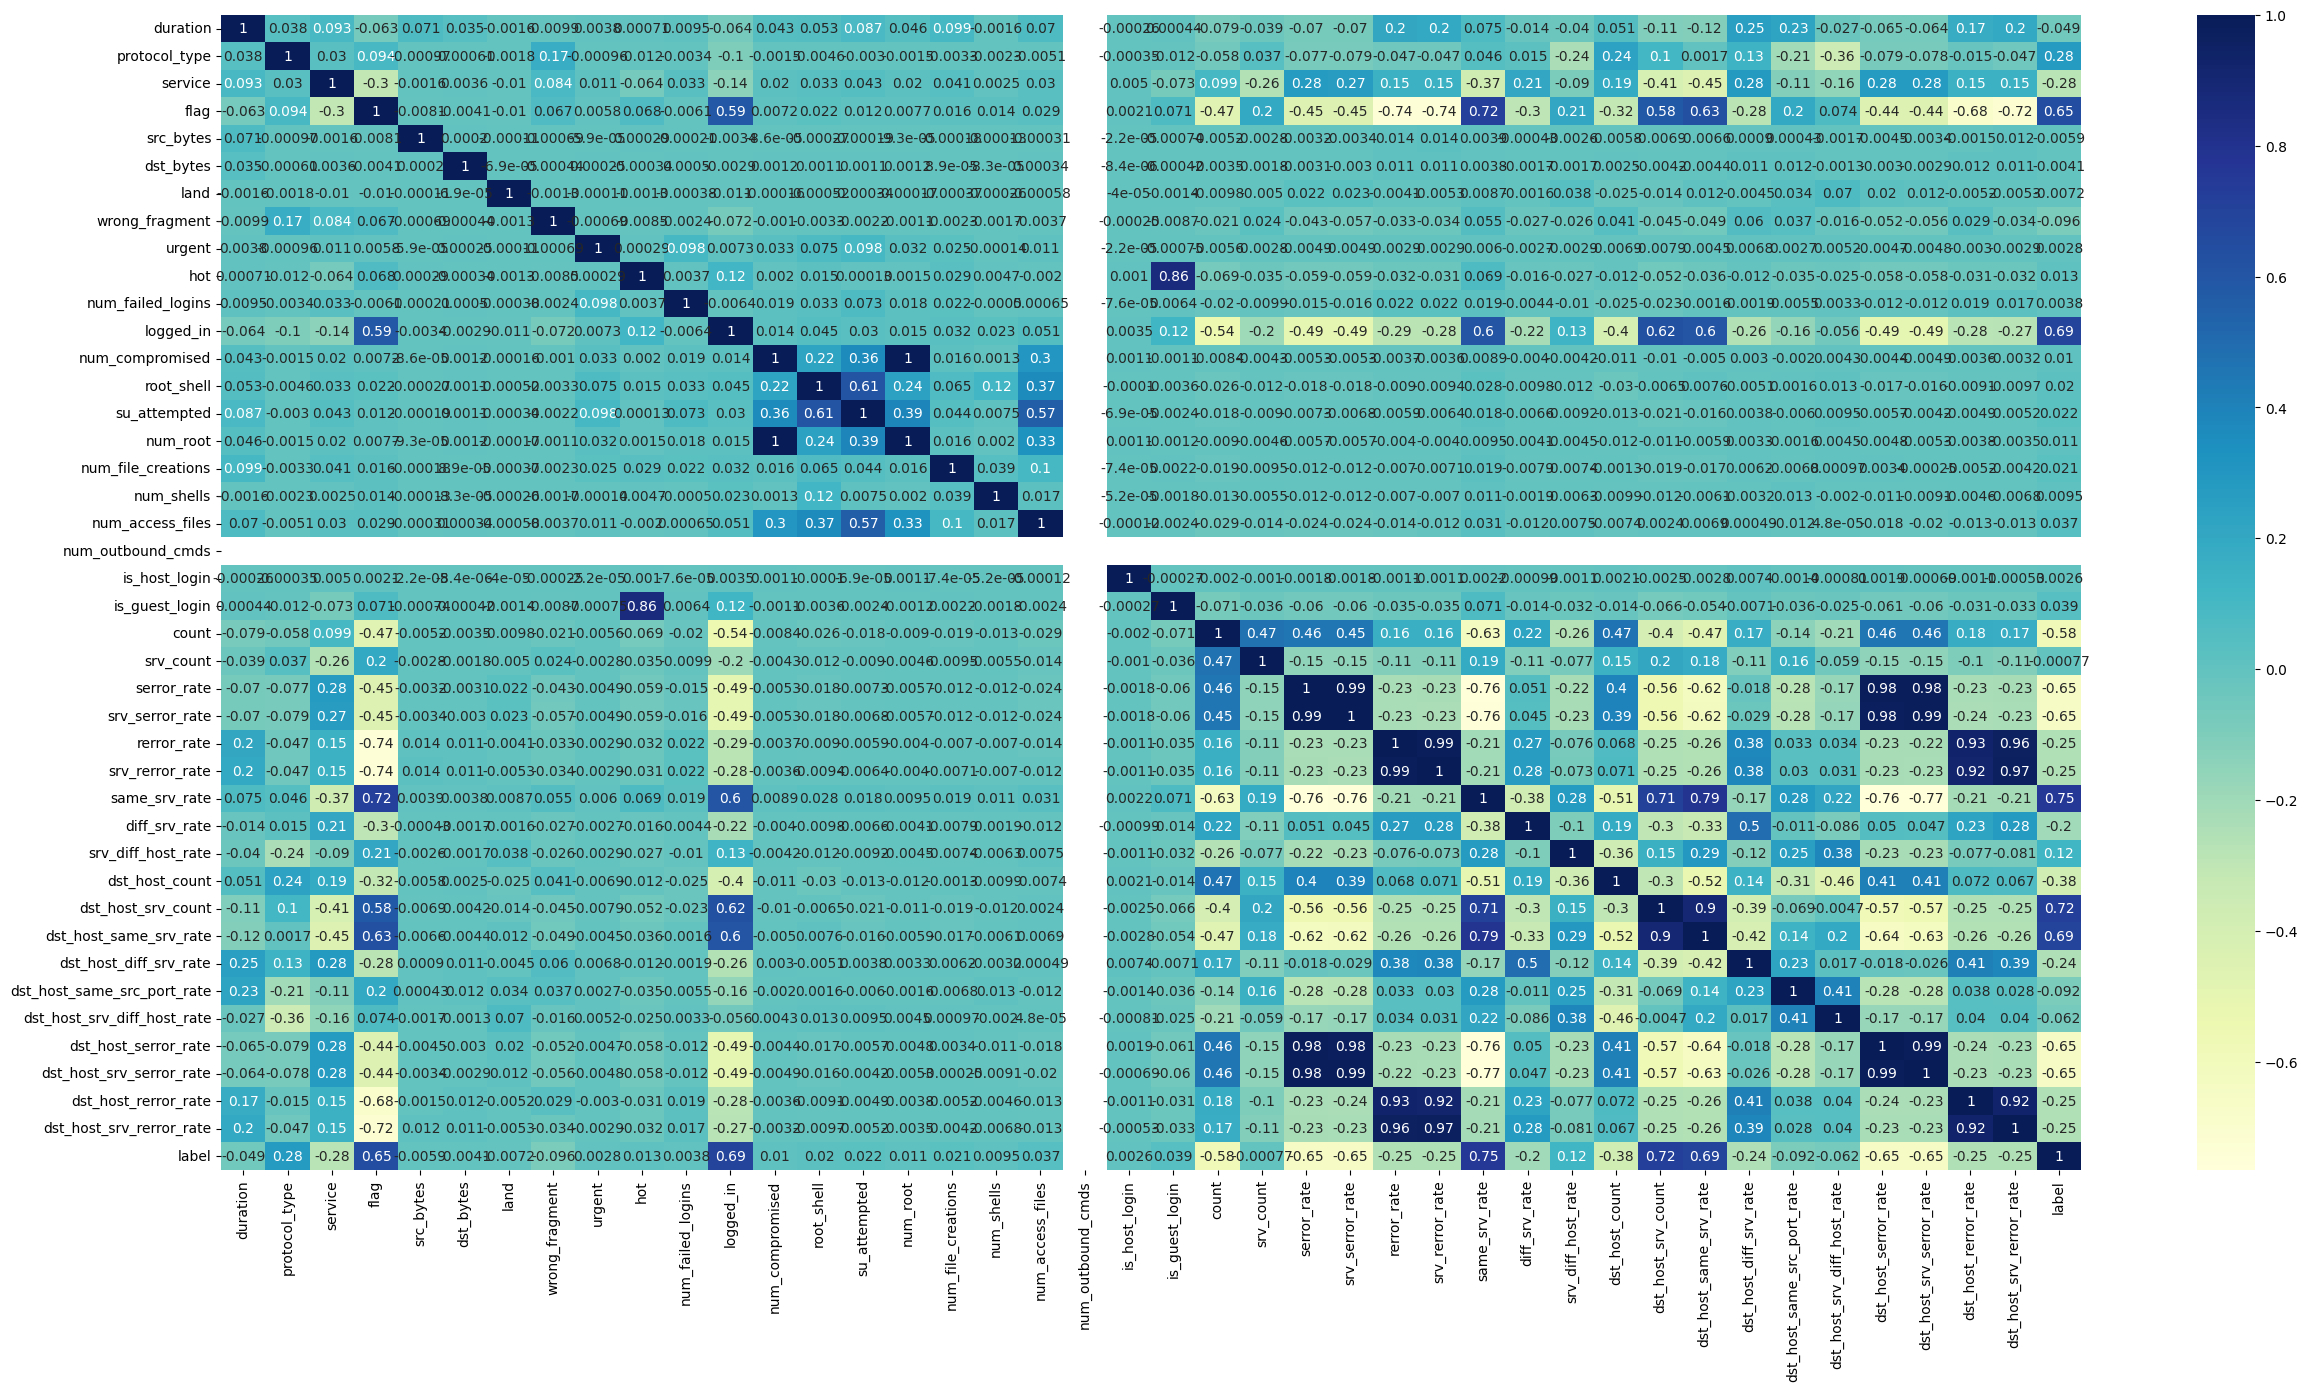

In [11]:
plt.figure(figsize=(30,15))
corr_matrix = df.corr()
sns.heatmap(corr_matrix, annot=True, cmap="YlGnBu")

We notice that:  

- Connection-related features, particularly rates, exhibit strong correlations.  
- Host-based traffic features, such as destination-related attributes, also show high correlations.

In [12]:
# Select upper triangle of the correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Find features with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

# Display the features to be dropped
print("Features to be dropped:", to_drop)

# Drop features with correlation greater than 0.95
df.drop(to_drop, axis=1, inplace=True)

Features to be dropped: ['num_root', 'srv_serror_rate', 'srv_rerror_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_srv_rerror_rate']


# Helping Function

In [39]:
def plot_confusion_matrix(y_true, y_pred, labels=None, cmap=plt.cm.viridis, values_format='d'):
    """
    Function to compute and display the confusion matrix.
    
    Args:
    - y_true: array-like, true labels.
    - y_pred: array-like, predicted labels from the model.
    - labels: list, class labels (default: None, will be determined automatically).
    - cmap: Colormap for the confusion matrix (default: plt.cm.viridis).
    - values_format: Format for the values in the matrix (default: 'd' for integers).
"""
    # Calcola la matrice di confusione
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    
    # Visualizza la matrice di confusione
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap=cmap, values_format=values_format)
    plt.show()



In [40]:
def plot_roc_curve(model, X_test, y_test):
    """
    Plots the ROC curve for a given model.
    
    Parameters:
    - model: The trained classifier (must have `predict_proba` method)
    - X_test: Test features
    - y_test: True test labels
    """
    # Check if the model supports probability predictions
    if hasattr(model, "predict_proba"):
        RocCurveDisplay.from_estimator(model, X_test, y_test, response_method="predict_proba")
        plt.title(f"ROC Curve for {model.__class__.__name__}")
        plt.show()
    else:
        print(f"Model {model.__class__.__name__} does not support probability predictions.")

# Splitting the dataset

Before training a machine learning model, it is essential to divide the dataset into training and testing sets to evaluate the model's performance on unseen data.

- Training Set: The training set is used to train the model. During this phase, the model learns the patterns and relationships in the data that allow it to make predictions.

- Testing Set: The testing set is used to evaluate the model's performance. It is important that the testing data is kept separate from the training data to ensure that the model can generalize to new, unseen data. Using a separate testing set helps to avoid overfitting, which occurs when a model is too closely tied to the training data and performs poorly on new data.

In [15]:
X = df.iloc[:, :-1] 
y = df.iloc[:, -1]   

# Split diretto in training (80%) e test (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

# Store index of the feature
X_index = X_train.columns

(100778, 35) (100778,) (25195, 35) (25195,)


# Feature Engineering

The `mutual_info_classif` function calculates the mutual information between each feature in `X_train` and the target variable `y_train`. Mutual information measures how much knowing the value of a feature reduces uncertainty about the target class. A high value indicates that the feature is highly informative for classification.

In [16]:
mutual_info = mutual_info_classif(X_train, y_train)
mutual_info = pd.Series(mutual_info)
mutual_info.index = X_index
mutual_info.sort_values(ascending=False)


src_bytes                      0.565676
service                        0.468054
dst_bytes                      0.439881
flag                           0.368620
same_srv_rate                  0.367252
diff_srv_rate                  0.360004
dst_host_srv_count             0.335212
dst_host_same_srv_rate         0.311812
logged_in                      0.290721
dst_host_diff_srv_rate         0.286263
serror_rate                    0.279573
count                          0.266121
dst_host_srv_diff_host_rate    0.186807
dst_host_count                 0.144017
dst_host_same_src_port_rate    0.131760
srv_diff_host_rate             0.097755
srv_count                      0.063143
protocol_type                  0.053467
rerror_rate                    0.038191
dst_host_rerror_rate           0.036547
duration                       0.026236
hot                            0.007489
wrong_fragment                 0.006105
num_access_files               0.004692
num_compromised                0.004594


In [17]:
from sklearn.feature_selection import SelectKBest
Select_features = SelectKBest(mutual_info_classif, k=30)
Select_features.fit(X_train, y_train)
X_index[Select_features.get_support()]

Index(['duration', 'protocol_type', 'service', 'flag', 'src_bytes',
       'dst_bytes', 'wrong_fragment', 'hot', 'logged_in', 'num_compromised',
       'root_shell', 'su_attempted', 'num_file_creations', 'num_shells',
       'num_access_files', 'is_guest_login', 'count', 'srv_count',
       'serror_rate', 'rerror_rate', 'same_srv_rate', 'diff_srv_rate',
       'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count',
       'dst_host_same_srv_rate', 'dst_host_diff_srv_rate',
       'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate',
       'dst_host_rerror_rate'],
      dtype='object')

In [18]:
# so the best 30 features are:
columns=['duration', 'protocol_type', 'service', 'flag', 'src_bytes',
       'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot',
       'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell',
       'su_attempted', 'num_access_files', 'count', 'srv_count', 'serror_rate',
       'rerror_rate', 'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate',
       'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate',
       'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
       'dst_host_srv_diff_host_rate', 'dst_host_rerror_rate']

X_train=X_train[columns]
X_test=X_test[columns]
print(X_train.shape)



(100778, 30)


# Scaling

Scaling ensures all features are on the same scale, improving model performance. We initially tried RobustScaler, which is designed to handle outliers, but it reduced accuracy, likely because the KDD dataset lacks significant outliers.

MinMaxScaler was chosen instead as it scales features to a 0-1 range, preserving their relationships. We fit the scaler on the training set and transformed both training and test sets to avoid data leakage. This approach improved accuracy, making MinMaxScaler the better choice.

In [19]:
scaler = MinMaxScaler()
# Fit the scaler to the features and transform them
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
df.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_rerror_rate,label
0,0,1,20,9,491,0,0,0,0,0,...,0.00,0.00,150,25,0.17,0.03,0.17,0.00,0.05,1
1,0,2,44,9,146,0,0,0,0,0,...,0.15,0.00,255,1,0.00,0.60,0.88,0.00,0.00,1
2,0,1,49,5,0,0,0,0,0,0,...,0.07,0.00,255,26,0.10,0.05,0.00,0.00,0.00,0
3,0,1,24,9,232,8153,0,0,0,0,...,0.00,0.00,30,255,1.00,0.00,0.03,0.04,0.00,1
4,0,1,24,9,199,420,0,0,0,0,...,0.00,0.09,255,255,1.00,0.00,0.00,0.00,0.00,1


# Logistic Regression

Logistic Regression's performance depends on the scale of input features. After applying MinMaxScaler, the accuracy improved to 95.30% on the test set. This highlights how scaling ensures all features contribute equally, avoiding dominance by features with larger ranges.

In [259]:
lr = LogisticRegression(max_iter=1000, random_state=42)
lr.fit(X_train_scaled, y_train)
 

# Predictions on the training and testing sets
y_train_pred = lr.predict(X_train_scaled)
y_test_pred = lr.predict(X_test_scaled)

# Accuracy on the testing set
test_accuracy_logistic = accuracy_score(y_test, y_test_pred)
print(f"Testing Accuracy: {test_accuracy_logistic:.4f}")

# Classification report for the testing set
print("\nClassification Report (Testing Set):\n", classification_report(y_test, y_test_pred))


Testing Accuracy: 0.9522

Classification Report (Testing Set):
               precision    recall  f1-score   support

           0       0.96      0.94      0.95     11773
           1       0.95      0.97      0.96     13422

    accuracy                           0.95     25195
   macro avg       0.95      0.95      0.95     25195
weighted avg       0.95      0.95      0.95     25195



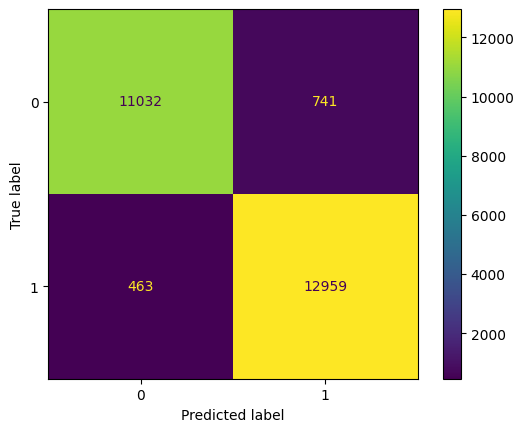

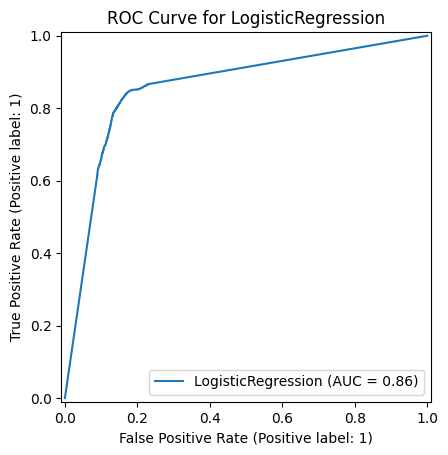

In [260]:
plot_confusion_matrix(y_true=y_test, y_pred=y_test_pred, labels=lr.classes_)
plot_roc_curve(lr, X_test, y_test)

# KNN

The K-Nearest Neighbors (KNN) classifier initially performed poorly with an AUC of 0.51, likely due to class imbalance. Attempts to address this imbalance using techniques like SMOTE, NearMiss, and class weights adjustment did not improve performance. The breakthrough came when the distance metric was changed from Euclidean to Manhattan (L1 norm), which proved more robust, especially for noisy or high-dimensional data. Additionally, using uniform weights for neighbors helped ensure that each neighbor had equal influence on the classification, further improving the model's performance.

Training Accuracy: 0.9955
Testing Accuracy: 0.9939

Classification Report (Testing Set):
               precision    recall  f1-score   support

           0       0.99      0.99      0.99     11773
           1       0.99      0.99      0.99     13422

    accuracy                           0.99     25195
   macro avg       0.99      0.99      0.99     25195
weighted avg       0.99      0.99      0.99     25195



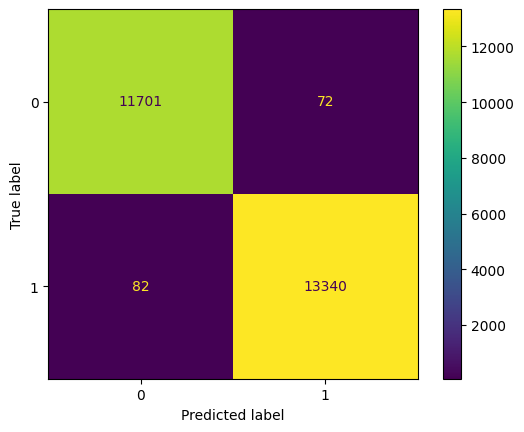

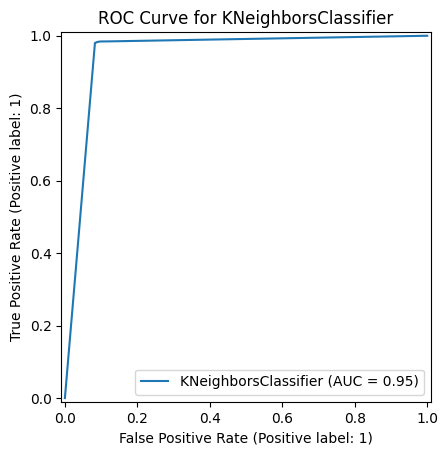

In [73]:
knn = KNeighborsClassifier(n_neighbors=10, weights='uniform', metric="manhattan") 
knn.fit(X_train_scaled, y_train)
y_pred = knn.predict(X_test_scaled)

train_accuracy_knn = knn.score(X_train_scaled, y_train)
print(f"Training Accuracy: {train_accuracy_knn:.4f}")

test_accuracy_knn = accuracy_score(y_test, y_pred)
print(f"Testing Accuracy: {test_accuracy_knn:.4f}")

print("\nClassification Report (Testing Set):\n", classification_report(y_test, y_pred))

plot_confusion_matrix(y_true=y_test, y_pred=y_pred, labels=knn.classes_)
plot_roc_curve(knn, X_test, y_test)

# Decision Tree

We experimented with hyperparameter tuning for the Decision Tree model, but it negatively impacted accuracy. Instead, we opted to keep more data for training and mitigate overfitting by setting the maximum depth of the tree to 8. This helps maintain a balance between model complexity and generalization, preventing the tree from becoming too deep and overly specialized to the training data.

Accuracy: 0.9965

Classification Report (Testing Set):
               precision    recall  f1-score   support

           0       1.00      0.99      1.00     11773
           1       0.99      1.00      1.00     13422

    accuracy                           1.00     25195
   macro avg       1.00      1.00      1.00     25195
weighted avg       1.00      1.00      1.00     25195



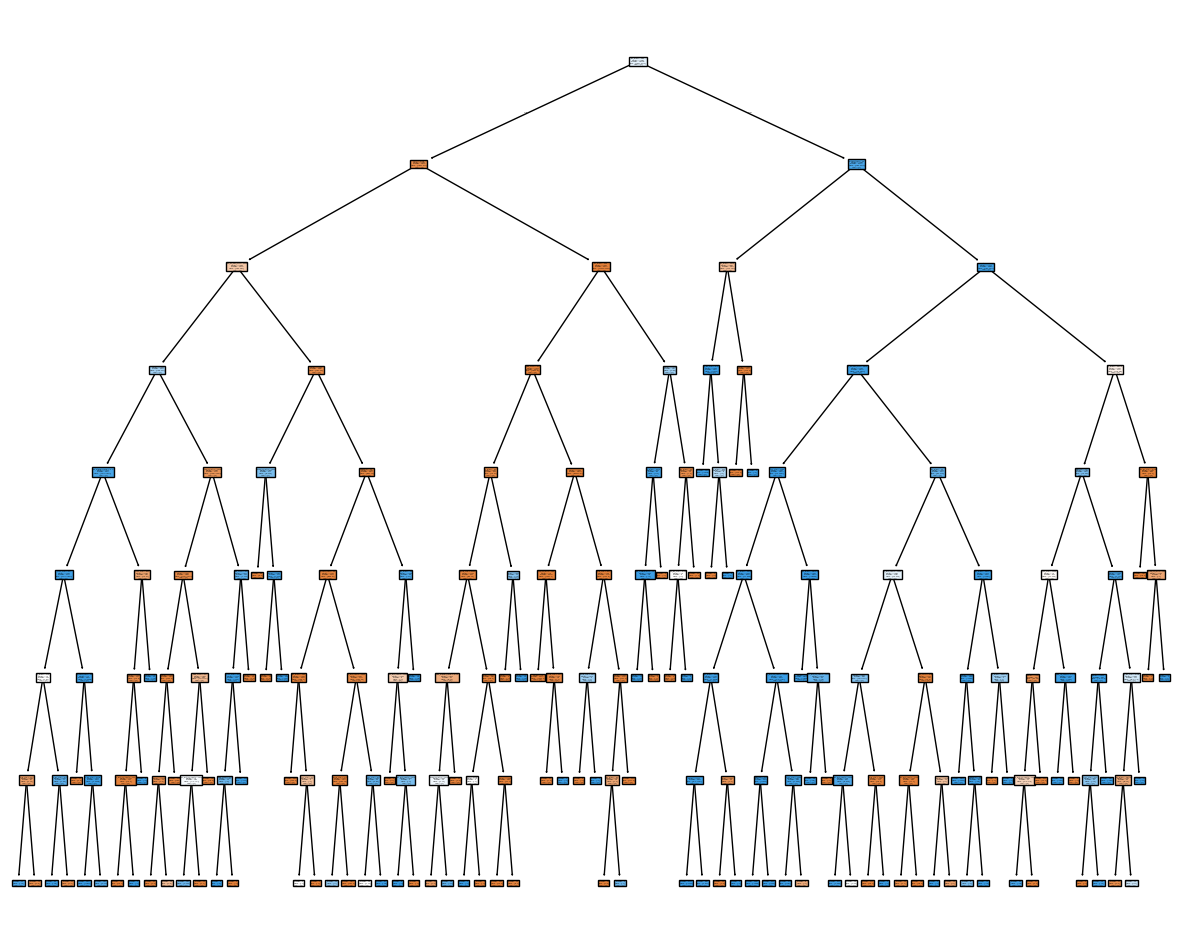

In [262]:
dt = DecisionTreeClassifier(criterion="entropy", max_depth=8, random_state=42)

dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)

test_accuracy_decision_tree = accuracy_score(y_test, y_pred)
print(f"Accuracy: {test_accuracy_decision_tree:.4f}")
print("\nClassification Report (Testing Set):\n", classification_report(y_test, y_pred))
fig = plt.figure(figsize=(15, 12))
plot_tree(dt, filled=True, feature_names=X.columns, class_names=True)
plt.show()

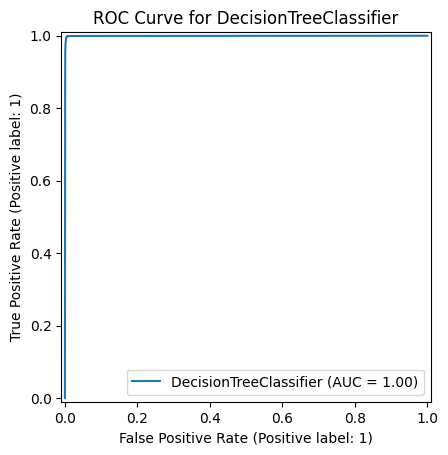

In [263]:
plot_roc_curve(dt, X_test, y_test)

# Random Forest

The Random Forest model, even without any hyperparameter tuning, provided the best results in the shortest time. By using the default settings with 100 estimators, it achieved high accuracy while maintaining efficiency.

Accuracy: 0.9978
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     11773
           1       1.00      1.00      1.00     13422

    accuracy                           1.00     25195
   macro avg       1.00      1.00      1.00     25195
weighted avg       1.00      1.00      1.00     25195



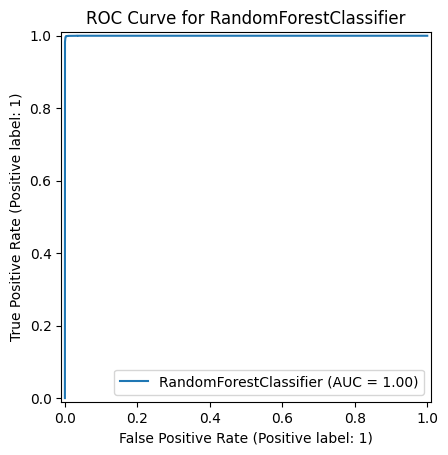

In [264]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)

rf.fit(X_train_scaled, y_train)

y_pred = rf.predict(X_test_scaled)

test_accuracy_random_forest = accuracy_score(y_test, y_pred)
print(f"Accuracy: {test_accuracy_random_forest:.4f}")

print(classification_report(y_test, y_pred))
plot_roc_curve(rf, X_test_scaled, y_test)

# Naive Bayes

Finally, we have Naïve Bayes, another fundamental machine learning classifier. However, we can observe that its accuracy does not generally compete with that of the Decision Tree model. This is likely due to the strong independence assumptions Naïve Bayes makes, which may not hold for our dataset, leading to lower performance.

Accuracy: 0.9010
              precision    recall  f1-score   support

           0       0.90      0.88      0.89     11773
           1       0.90      0.92      0.91     13422

    accuracy                           0.90     25195
   macro avg       0.90      0.90      0.90     25195
weighted avg       0.90      0.90      0.90     25195



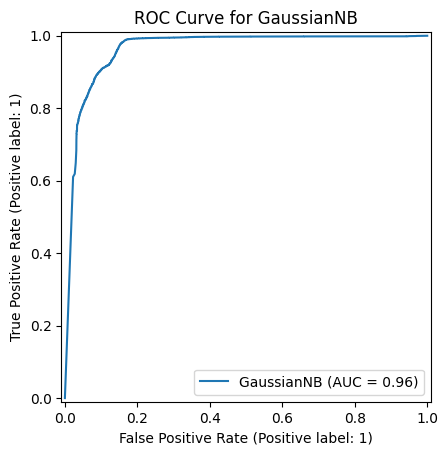

In [265]:
nb = GaussianNB()
nb.fit(X_train_scaled, y_train)

# Make predictions on the test set
y_pred = nb.predict(X_test_scaled)

# Evaluate the model
test_accuracy_naive = accuracy_score(y_test, y_pred)
print(f"Accuracy: {test_accuracy_naive:.4f}")

# Print classification report
print(classification_report(y_test, y_pred))
plot_roc_curve(nb, X_test_scaled, y_test)

# Results  

We've reached the conclusion, and we can see that the dataset performs best with ensemble models and tree-based approaches like Decision Tree. These are followed by KNN, Logistic Regression, and finally Naïve Bayes, which shows the lowest performance.

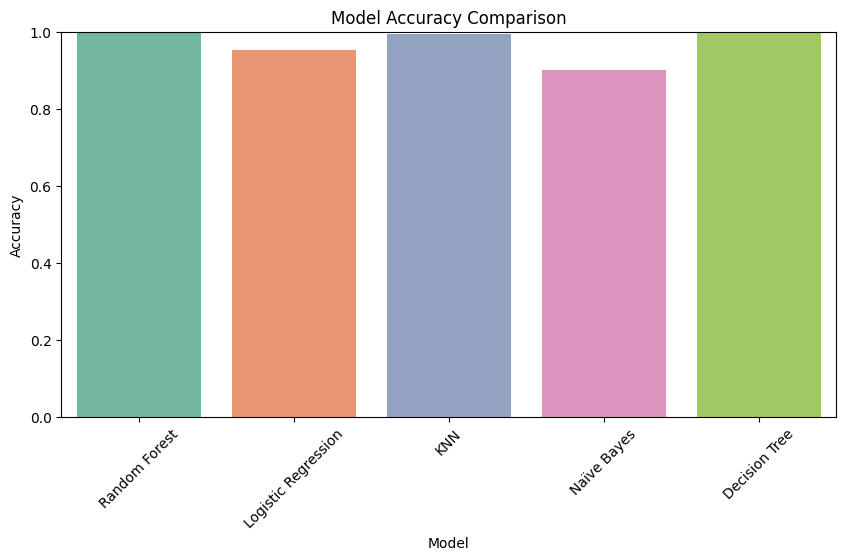

In [266]:
model_names = ["Random Forest", "Logistic Regression", "KNN", "Naïve Bayes", "Decision Tree"]
accuracies = [test_accuracy_random_forest, test_accuracy_logistic, test_accuracy_knn, test_accuracy_naive, test_accuracy_decision_tree] 

# Create a DataFrame
results_df = pd.DataFrame({"Model": model_names, "Accuracy": accuracies})

# Bar plot
plt.figure(figsize=(10, 5))
sns.barplot(x="Model", y="Accuracy", data=results_df, palette="Set2")
plt.ylim(0, 1)  # Ensure the y-axis is between 0 and 1
plt.title("Model Accuracy Comparison")
plt.ylabel("Accuracy")
plt.xticks(rotation=45)
plt.show()



# Bonus

Since neural networks are known to be more computationally expensive and time-consuming compared to traditional machine learning models, we might wonder: Is it worth trying?

To answer this, we train a FeedForward Neural Network and evaluate its performance. Below, we define a neural network with multiple layers, incorporating Dropout layers to reduce overfitting. The model is then compiled using the Adam optimizer and binary cross-entropy loss, which is suitable for binary classification problems.

In [ ]:
nn = Sequential() 
nn.add(Dense(units=128, input_dim=X_train.shape[1], activation='relu'))
nn.add(Dropout(0.3))  
nn.add(Dense(units=64, activation='relu'))
nn.add(Dropout(0.3))  
nn.add(Dense(units=32, activation='relu'))
nn.add(Dropout(0.3))  
nn.add(Dense(units=16, activation='relu'))
nn.add(Dropout(0.3))  
nn.add(Dense(1, activation='sigmoid'))

# defining loss function, optimizer, metrics and then compiling model
nn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

history = nn.fit(X_train_scaled, y_train, epochs=100, batch_size=5000,validation_split=0.2)


Epoch 1/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.6088 - loss: 0.6702 - val_accuracy: 0.8958 - val_loss: 0.5222
Epoch 2/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.8474 - loss: 0.4868 - val_accuracy: 0.9092 - val_loss: 0.2550
Epoch 3/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.8994 - loss: 0.2831 - val_accuracy: 0.9534 - val_loss: 0.1407
Epoch 4/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.9432 - loss: 0.1838 - val_accuracy: 0.9635 - val_loss: 0.1160
Epoch 5/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.9569 - loss: 0.1542 - val_accuracy: 0.9674 - val_loss: 0.1071
Epoch 6/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.9627 - loss: 0.1389 - val_accuracy: 0.9690 - val_loss: 0.0997
Epoch 7/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.9668 - loss: 0.1255 - val_accuracy: 0.9698 - val_loss: 0.0930
Epoch 8/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.9673 - loss: 0.1170 - val_accuracy: 0.

In [ ]:
# predicting target attribute on testing dataset
test_results = nn.evaluate(X_test_scaled, y_test, verbose=1)
print(f'Test results - Loss: {test_results[0]} - Accuracy: {test_results[1]*100}%')

788/788 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9934 - loss: 0.0186
Test results - Loss: 0.018355613574385643 - Accuracy: 99.36495423316956%


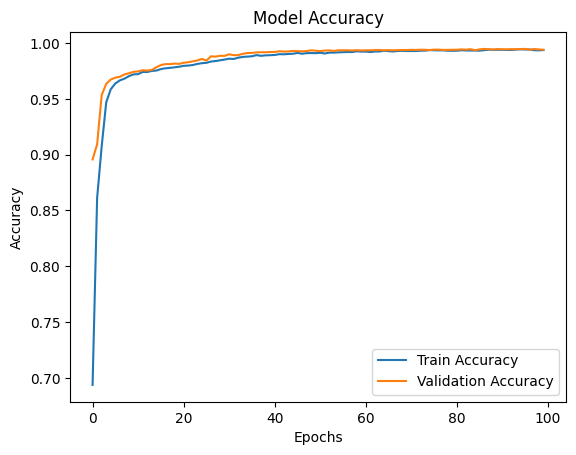

In [35]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model Accuracy')
plt.show()

The neural network achieved high accuracy and a very low loss, suggesting that it is effective for this classification task. However, if resources are limited or the improvement in accuracy is marginal compared to simpler models, it might be better to opt for less computationally expensive approaches like decision trees or KNN.